# Data Preparation

In [ ]:
#knitr::purl(here("Rmd/childcare_article_analyses.Rmd"), here("R/childcare_article_analyses.R"))

In [1]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)
library(future)
library(furrr)
library(broom)
library(ggpubr)

Loading required package: permute
Loading required package: lattice
This is vegan 2.5-3
Loading required package: phyloseq
Loading required package: ggplot2

microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2018 Leo Lahti et al. <microbiome.github.io>


Attaching package: ‘microbiome’

The following object is masked from ‘package:base’:

    transform

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.0.0     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.3.1     ✔ stringr 1.3.1
✔ tibble  2.0.0     ✔ forcats 0.3.0
Warning message:
“package ‘tibble’ was built under R version 3.5.2”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
here() starts at /Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo
Loading required package: magrittr

Attaching package: ‘magri

In [2]:
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

This is loo version 2.0.0.
**NOTE: As of version 2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. Visit mc-stan.org/loo/news for details on other changes.

Attaching package: ‘glue’

The following object is masked from ‘package:dplyr’:

    collapse



In [3]:
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

Loading required package: DBI
Loading required package: preprocessCore
Loading required package: RMySQL
Warning message:
“package ‘RMySQL’ was built under R version 3.5.2”Loading required package: RPA
Loading required package: affy
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colMeans, colSums, colnames,
    dirname, do.call, duplicated, eval, evalq, get, grep,

In [4]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 

In [5]:
head(meta_new)

subject_id sample_id time cc  age_d  age_d_s    bf_count bf_count_s  bf_ratio
1 207        sa_10000  post no   98.00  0.0320946 6.00      0.43948544 1       
2 388        sa_10038  post yes  98.00  0.0320946 0.00     -1.65710371 0       
3 381        sa_10118  post yes 108.00  0.5275689 6.59      0.64565004 1       
4 283        sa_10211  post yes 107.03  0.4795079 5.00      0.09005391 1       
5 216        sa_10230  post no  100.00  0.1311895 7.00      0.78891696 1       
6 277        sa_10247  pre  yes  79.00 -0.9093066 6.10      0.47442859 1

In [6]:
# create catories for bf and childcare and specifically for ccyes vs rest
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF")),
      ccpost = ifelse(groups == "CCpost", 1, 0)) %>% 
  mutate(
      groups = as.factor(groups), 
      bf = as.factor(bf), 
      ccpost = as.factor(ccpost))

In [7]:
# add confounding variables
confounders <- foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), to.data.frame = T) %>%
    select(ID, SIBLINGS, childsex) %>% rename(sibling = SIBLINGS, subject_id = ID) %>%
    mutate(sibling = ifelse(sibling == "at leat 1 sibling", 1, ifelse(sibling == "firstborn", 0, 1))) %>%
    filter(subject_id %in% meta_new$subject_id)
meta_new <- meta_new %>% left_join(confounders, by = "subject_id")

Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 2 added in variable: SIBLINGS”Warning message in foreign::read.spss(here("data/meta_data/bibo_confounders.sav"), :
“Undeclared level(s) 6, 999 added in variable: DELIVERYmode”

In [8]:
# create new pseq object (read.R results in the object "genus" Leo created)
otu <- otu_to_df(genus, transpose = FALSE)
otu <- otu %>% 
    select(species, meta_new$sample_id) %>% 
    df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()
meta <- sd_to_df(pseq)
# clr and relative abundance transformation to deal with compositionality of mb data
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.rel <- microbiome::transform(pseq, "compositional")

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

# PCA

A PCA using CLR transformed values displays the Aitchison distance.

In [11]:
otus.clr <- otu_to_df(pseq.clr)
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium \\(sensu stricto\\)")] <- "Clostridium_sensu_stricto"
colnames(otus.clr) <- c("sample_id", gsub("_", "", colnames(otus.clr)[-1]))
colnames(otus.clr) <- gsub("\\.", "", colnames(otus.clr))
colnames(otus.clr) <- gsub(" ", "", colnames(otus.clr))
genus <- colnames(otus.clr)[-1]
data <- sd_to_df(pseq.clr) %>%
    left_join(otus.clr, by = "sample_id")
data$sibling <- as.factor(data$sibling)
data$childsex <- as.factor(data$childsex)


# PCA with CLR values (euclidean distance of clr transformed values = Aitchison distance) 
pcx <- prcomp(otus.clr %>% column_to_rownames("sample_id"))
# extract loadings
pcx_rot <- 
    pcx$rotation %>%
        as.tibble() %>%
        mutate_all(function(x) x*10) %>%
        add_column(genus = rownames(pcx$rotation))

# add PCs to data
princomps <- pcx$x %>% as.data.frame() %>%
    rownames_to_column("sample_id") %>%
    select(PC1, PC2, PC3, PC4, PC5, sample_id)
data <- data %>% left_join(princomps, by = "sample_id") 
                   
# how much variance do pcs explain?
pc1 <- round(pcx$sdev[1]^2/sum(pcx$sdev^2),2)
pc2 <- round(pcx$sdev[2]^2/sum(pcx$sdev^2),2)
pc3 <- round(pcx$sdev[3]^2/sum(pcx$sdev^2),2)
pc4 <- round(pcx$sdev[4]^2/sum(pcx$sdev^2),2)
pc5 <- round(pcx$sdev[5]^2/sum(pcx$sdev^2),2)                   

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

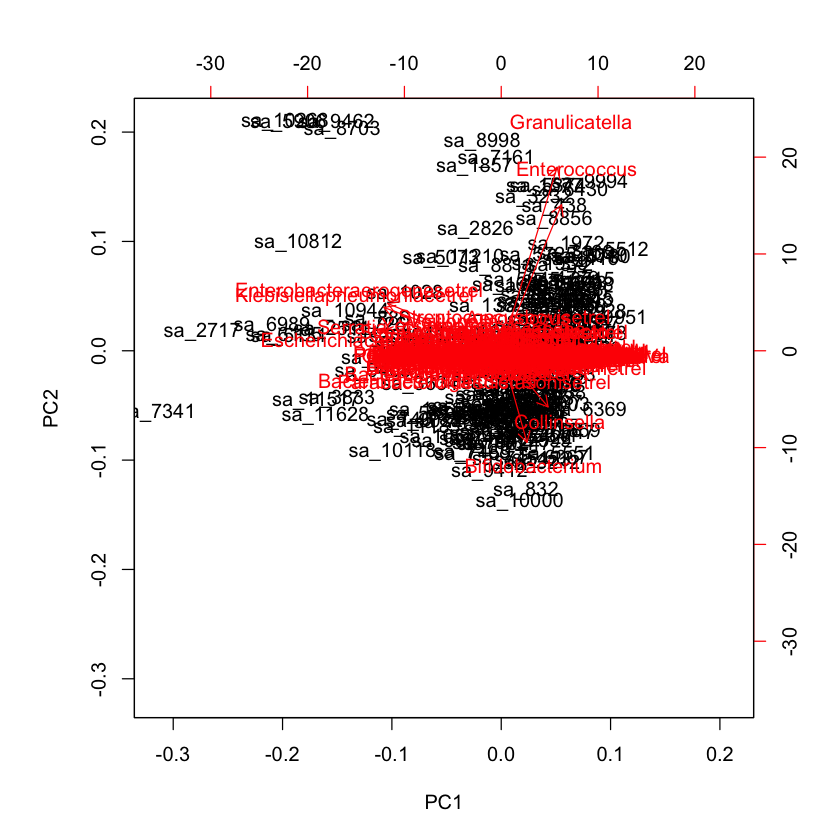

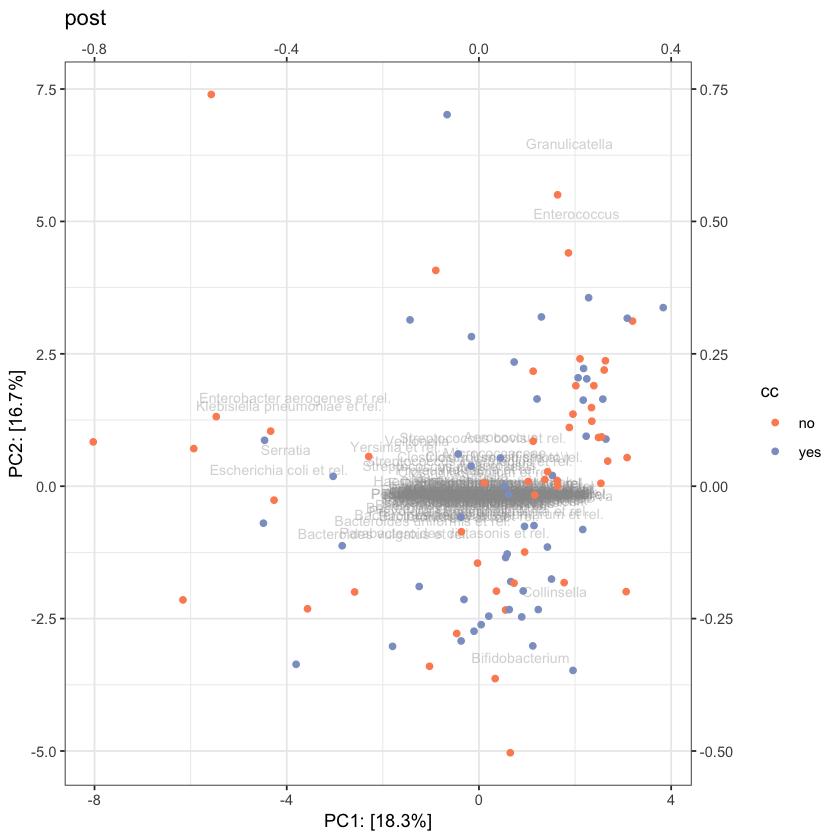

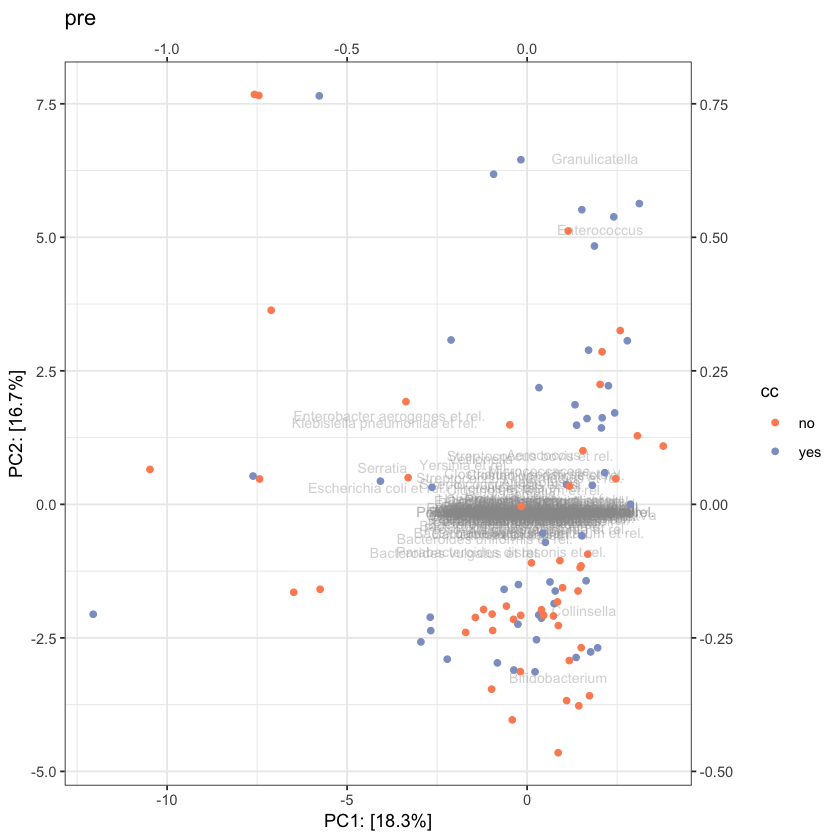

[[1]]

[[2]]

[[3]]

[[4]]


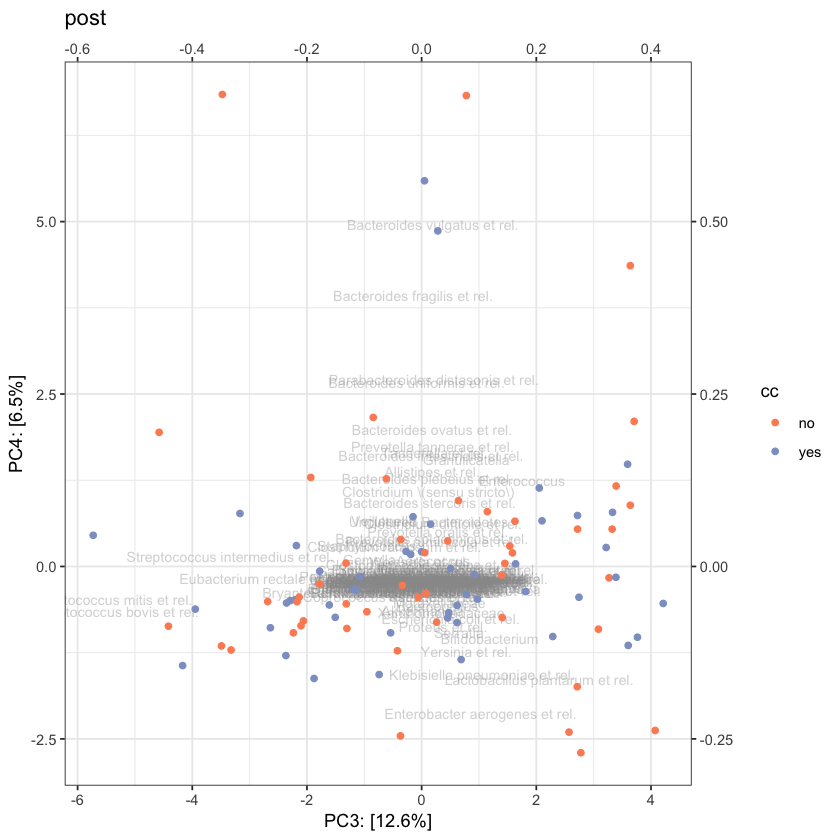

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

Warning message in class(x) <- c(subclass, tibble_class):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

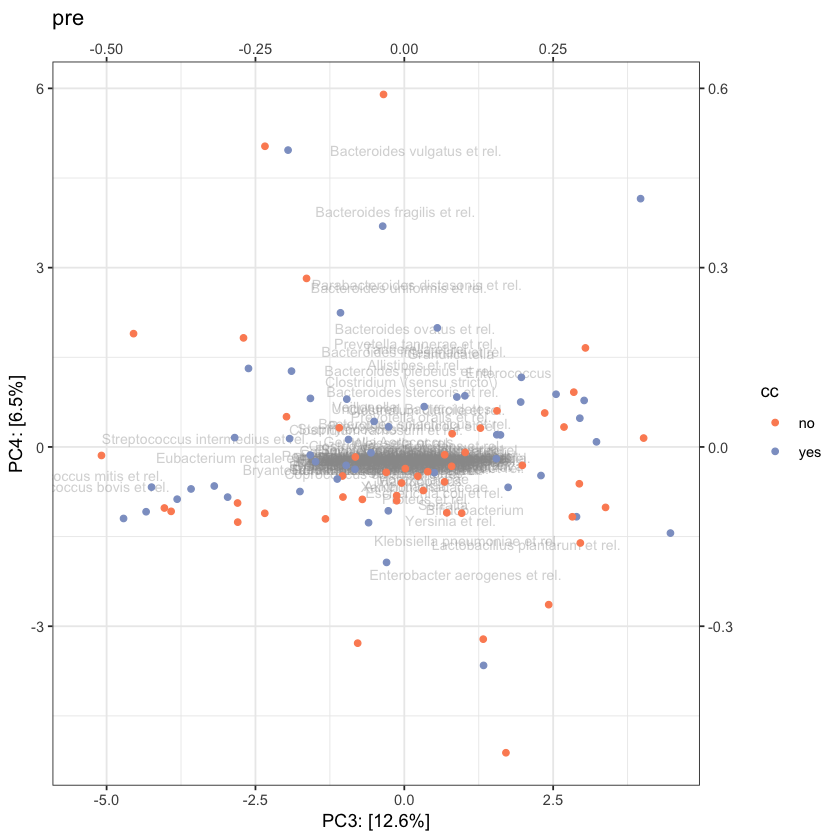

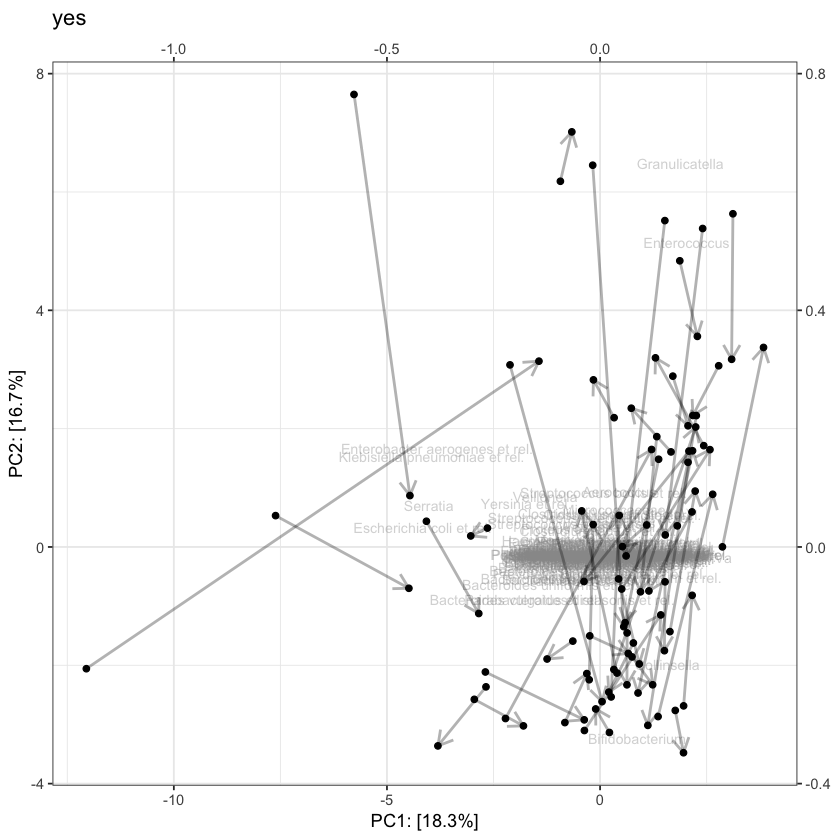

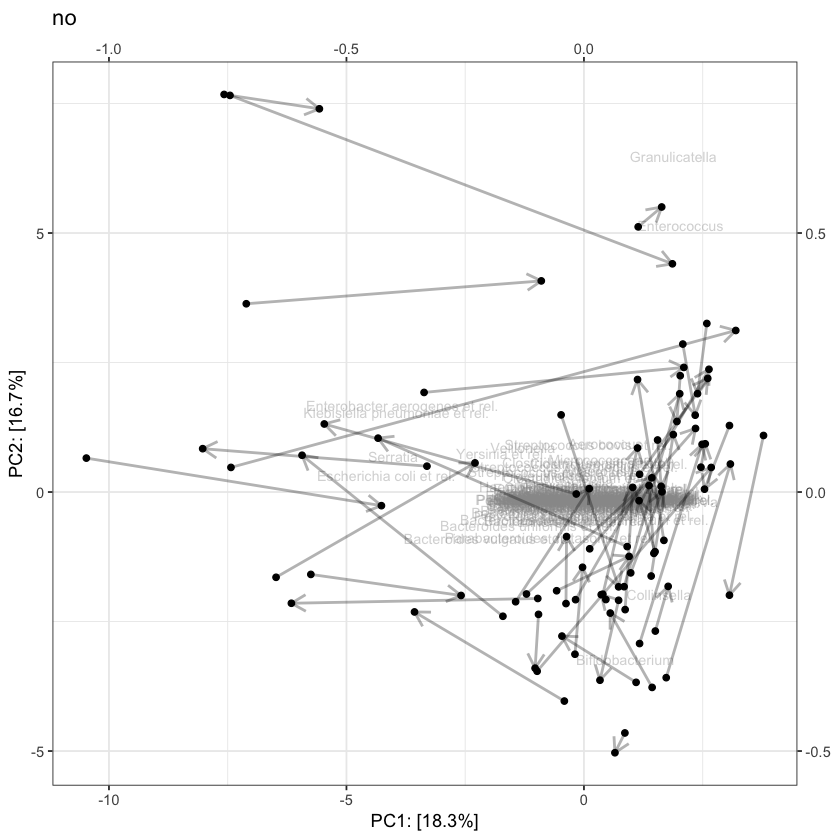

[[1]]

[[2]]

[[3]]

[[4]]


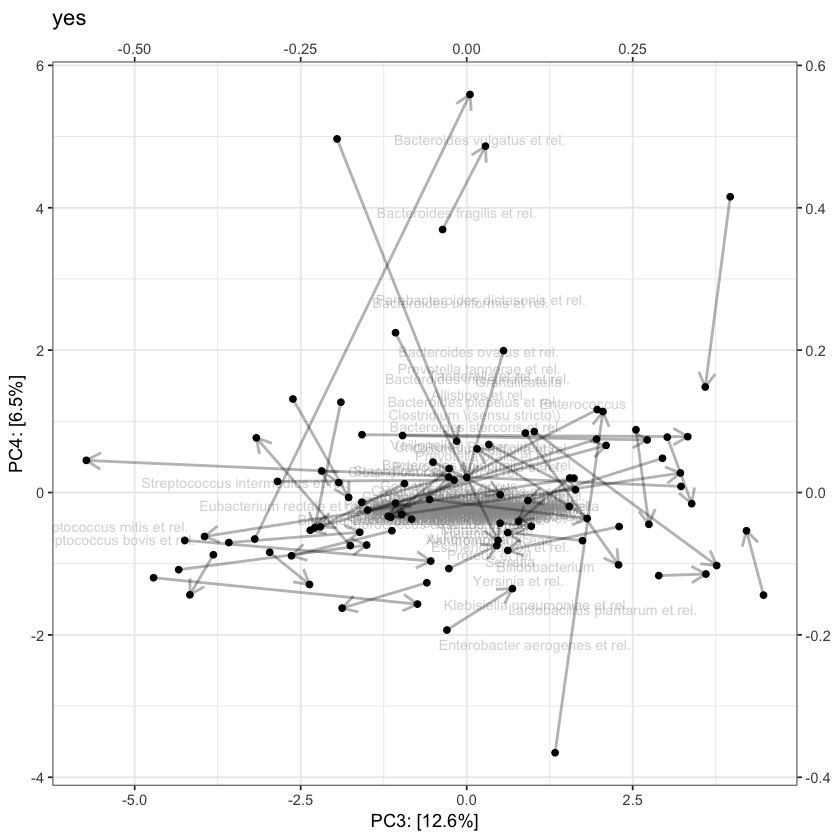

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

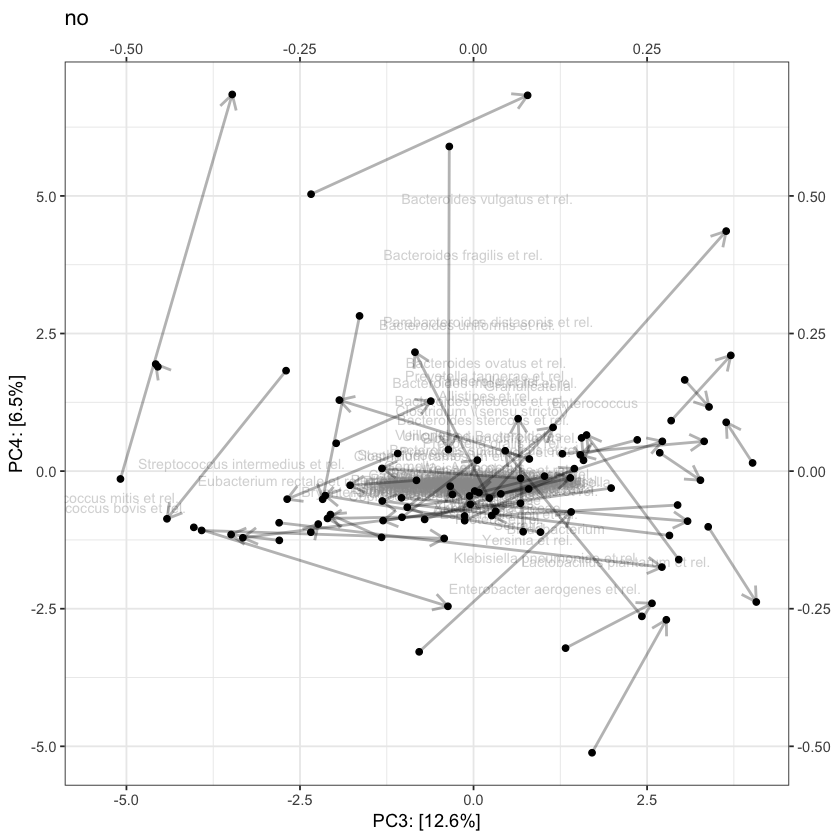

In [12]:
p_versions <- c(1:4)
# just to compare with others:
stats::biplot(pcx)
# biplots
biplot_cc <- biplot(pseq.clr, color = "cc", split_by = "time")
biplot_cc
map2(biplot_cc, p_versions, ~ggsave(plot = .x, filename = here(glue("fig/aitchison_pca_cc_{.y}.png"))))


biplot_time <- biplot(pseq.clr, split_by = "cc", connect_series = "time")
biplot_time
map2(biplot_time, p_versions, ~ggsave(plot = .x, filename = here(glue("fig/aitchison_pca_time_{.y}.png"))))



# Multiple Impuation

In [13]:
# I recode the contrasts so that I have the comparisons I want:
# the intercept will reflect our group we want to compare to others (cc post)
# the cc coefficient then compares to no cc post, the time coefficent 
# to cc pre and the interaction to no cc pre
# contrasts(data$cc)[1, 1] <- 1
# contrasts(data$cc)[2, 1] <- 0
# contrasts(data$time)[1, 1] <- 1
# contrasts(data$time)[2, 1] <- 0

library(mice)
# Next I impute data using predictive mean matching (PMM). PMM is
# less difficult to specify. I use the PCs to impute instead of all 
# genus abundances since these are correlated
data_imp <- data %>% 
    select(
        -everything(), 
        subject_id, 
        age_d_s, 
        time, 
        cc, 
        bf_count_s, 
        sibling,
        PC1,
        PC2,
        PC3,
        PC4,
        PC5) %>%
    mice(m = 10, method = "pmm", print = F, seed = 412) %>%
    mice::complete("all")
# This I use to join genus abundances again
deselect_col <- colnames(data_imp[[1]])
data_lj <- data %>% select(-deselect_col, subject_id, time)
data_imp <- map(data_imp, ~.x %>% left_join(data_lj, by = c("subject_id", "time")))


Attaching package: ‘mice’

The following objects are masked from ‘package:BiocGenerics’:

    cbind, rbind

The following object is masked from ‘package:tidyr’:

    complete

The following objects are masked from ‘package:base’:

    cbind, rbind



# PERMANOVA
I cannot use Bray Curtis distance for CLR transformed data. Thus I do it once with relative abundance and for clr transformed data I use Euclidean distance, which then is the Aitchison distance. I

In [14]:
# clr/euclidean
#meta.clr <- sd_to_df(pseq.clr) %>% select(-sibling) %>% na.omit()
#otus.clr <- otu_to_df(pseq.clr, transpose = F) %>% 
#    column_to_rownames("species") %>%
#    select(meta.clr$sample_id) %>%
#    t() 

# Homogeneity assumption (for sibling I use one of the imputed sets)
dist <- vegdist(otus.clr[, -1], method = "euclidean")
hg_cc <- anova(betadisper(dist, data_imp[[1]]$cc))
hg_time <- anova(betadisper(dist, data_imp[[1]]$time))
hg_groups <- anova(betadisper(dist, data_imp[[1]]$groups))
hg_childsex <- anova(betadisper(dist, data_imp[[1]]$childsex))
hg_sibling <- anova(betadisper(dist, data_imp[[1]]$sibling))
hg_groups

Df  Sum Sq     Mean Sq  F value  Pr(>F)   
Groups      3   20.81327 6.937756 1.194218 0.3132096
Residuals 192 1115.41543 5.809455       NA        NA

In [15]:
fit_pm <- function(data_imp) {
    otus <- data_imp %>% 
        select(genus, sample_id) %>% 
        column_to_rownames("sample_id")
    meta <- data_imp %>% 
        select(-everything(), subject_id, sample_id, time, cc, age_d_s, bf_count_s, sibling, childsex) %>% 
        column_to_rownames("sample_id")
    pm <- adonis(
        otus ~ time * cc + age_d_s + bf_count_s, 
        method = "euclidean", 
        data =  meta)
    list(aov = pm$aov.tab, coefs = coefficients(pm))
}
plan(multiprocess)
pms <- future_map(data_imp, fit_pm)

In [16]:
map(pms, ~.x$aov %>% as.data.frame())

$`1`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4691090 0.007321524  0.122
cc           1   52.63602  52.63602 1.3231168 0.006593951  0.169
age_d_s      1   79.55307  79.55307 1.9997334 0.009965970  0.025
bf_count_s   1  197.05994 197.05994 4.9535149 0.024686583  0.001
time:cc      1   36.22883  36.22883 0.9106877 0.004538549  0.517
Residuals  190 7558.54947  39.78184        NA 0.946893423     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`2`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4715484 0.007321524  0.117
cc           1   52.63602  52.63602 1.3253138 0.006593951  0.197
age_d_s      1   79.55307  79.55307 2.0030538 0.009965970  0.023
bf_count_s   1  208.02112 208.02112 5.2377298 0.026059739  0.001
time:cc      1   37.79749  37.79749 0.9516968 0.004735061  0.464
Residuals  190 7546.01963  39.71589        NA 0.945323755     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`3`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4719627 0.007321524  0.131
cc           1   52.63602  52.63602 1.3256869 0.006593951  0.163
age_d_s      1   79.55307  79.55307 2.0036178 0.009965970  0.025
bf_count_s   1  209.94540 209.94540 5.2876693 0.026300803  0.001
time:cc      1   37.99713  37.99713 0.9569928 0.004760071  0.451
Residuals  190 7543.89571  39.70471        NA 0.945057682     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`4`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4730745 0.007321524  0.118
cc           1   52.63602  52.63602 1.3266882 0.006593951  0.186
age_d_s      1   79.55307  79.55307 2.0051311 0.009965970  0.028
bf_count_s   1  215.91190 215.91190 5.4420486 0.027048254  0.001
time:cc      1   37.72436  37.72436 0.9508407 0.004725901  0.470
Residuals  190 7538.20197  39.67475        NA 0.944344401     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`5`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4739710 0.007321524  0.140
cc           1   52.63602  52.63602 1.3274957 0.006593951  0.197
age_d_s      1   79.55307  79.55307 2.0063515 0.009965970  0.029
bf_count_s   1  219.97862 219.97862 5.5479244 0.027557709  0.001
time:cc      1   38.24279  38.24279 0.9644943 0.004790846  0.442
Residuals  190 7533.61683  39.65061        NA 0.943770000     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`6`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4727266 0.007321524  0.134
cc           1   52.63602  52.63602 1.3263750 0.006593951  0.191
age_d_s      1   79.55307  79.55307 2.0046577 0.009965970  0.026
bf_count_s   1  215.34611 215.34611 5.4265062 0.026977374  0.001
time:cc      1   36.50982  36.50982 0.9200108 0.004573749  0.506
Residuals  190 7539.98231  39.68412        NA 0.944567433     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`7`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4719511 0.007321524  0.128
cc           1   52.63602  52.63602 1.3256765 0.006593951  0.186
age_d_s      1   79.55307  79.55307 2.0036021 0.009965970  0.029
bf_count_s   1  208.54251 208.54251 5.2522950 0.026125056  0.001
time:cc      1   39.34093  39.34093 0.9908299 0.004928414  0.437
Residuals  190 7543.95480  39.70503        NA 0.945065084     NA
Total      195 7982.47118        NA        NA 1.000000000     NA

$`8`
            Df  SumsOfSqs   MeanSqs   F.Model          R2 Pr(>F)
time         1   58.44386  58.44386 1.4717937 0.007321524  0.116
cc           1   52.63602  52.63602 1.3255347 0.006593951  0.200
age_d_s      1   79.55307  79.55307 2.0033877 0.009965970  0.024
bf_count_s   1  210.52827 210.52827 5.3017407 0.02637

In [17]:
pm_table <- pms[[1]]$aov %>%
    rownames_to_column("Model Parameters") %>%
    mutate_if(is.numeric, funs(round(., 3))) %>%
    mutate(
      MeanSqs = ifelse(is.na(MeanSqs), "-", MeanSqs),
      F.Model = ifelse(is.na(F.Model), "-", F.Model),
      `Pr(>F)` = ifelse(is.na(`Pr(>F)`), "-", `Pr(>F)`) 
    ) %>%
    select(`Model Parameters`,SumsOfSqs, MeanSqs, F.Model, Df,`Pr(>F)`, R2)

colnames(pm_table) <- c("Model Parameter", "Sum of Squares", "Mean Sum of Squares", "F", "Df", "p", "R Square" )
papaja::apa_table(pm_table)



\begin{table}[tbp]
\begin{center}
\begin{threeparttable}
\begin{tabular}{lllllll}
\toprule
Model Parameter & \multicolumn{1}{c}{Sum of Squares} & \multicolumn{1}{c}{Mean Sum of Squares} & \multicolumn{1}{c}{F} & \multicolumn{1}{c}{Df} & \multicolumn{1}{c}{p} & \multicolumn{1}{c}{R Square}\\
\midrule
time & 58.44 & 58.444 & 1.469 & 1.00 & 0.122 & 0.01\\
cc & 52.64 & 52.636 & 1.323 & 1.00 & 0.169 & 0.01\\
age\_d\_s & 79.55 & 79.553 & 2 & 1.00 & 0.025 & 0.01\\
bf\_count\_s & 197.06 & 197.06 & 4.954 & 1.00 & 0.001 & 0.02\\
time:cc & 36.23 & 36.229 & 0.911 & 1.00 & 0.517 & 0.00\\
Residuals & 7,558.55 & 39.782 & - & 190.00 & - & 0.95\\
Total & 7,982.47 & - & - & 195.00 & - & 1.00\\
\bottomrule
\end{tabular}
\end{threeparttable}
\end{center}
\end{table}



Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


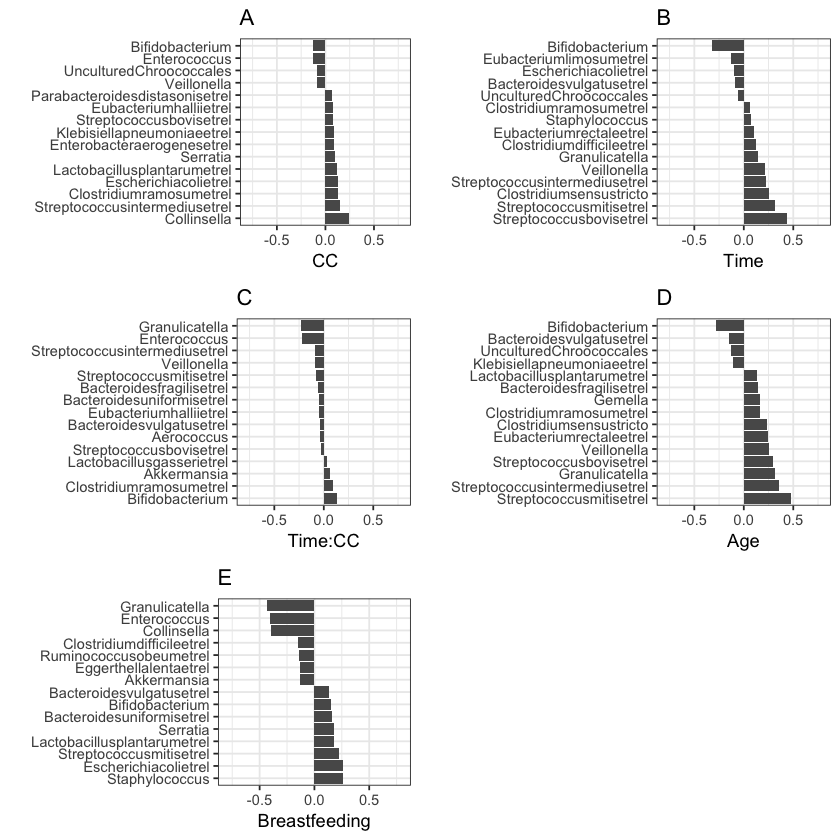

In [18]:
coef_v <- c("cc1", "time1", "time1:cc1", "age_d_s", "bf_count_s")
coef_title <- c("CC", "Time", "Time:CC", "Age", "Breastfeeding")
pmps <- map2(coef_v, coef_title, function(.x, .y) {
    coef <- pms[[1]]$coefs[.x,] 
    # make plot that I can manipulate better for apa6th in case
    coef_top <- 
        coef[rev(order(abs(coef)))[1:15]] %>%
        as.data.frame() %>%
        rownames_to_column("top_taxa") 
    colnames(coef_top) <- c("top_taxa", "coef_top")

    coef_top <- coef_top %>% arrange(desc(coef_top)) %>%
                mutate(top_taxa = factor(top_taxa, levels = top_taxa))
     p <- ggplot(coef_top, aes(top_taxa, coef_top)) +
            geom_bar(stat="identity") +
            ylim(-0.8, 0.8) +
            xlab("") + ylab(.y) +
            ggtitle(glue::glue("Coefficient: {.x}")) +
            coord_flip() +
            theme_bw()
    ggsave(here(glue("fig/permanova_{.x}_clr.png")))
    p
})
ggpubr::ggarrange(
    pmps[[1]] + ggtitle('A'), 
    pmps[[2]] + ggtitle('B'), 
    pmps[[3]] + ggtitle('C'), 
    pmps[[4]] + ggtitle('D'), 
    pmps[[5]] + ggtitle('E'), 
    nrow = 3, ncol = 2, common.legend = T)


# Hierarchical Generalized Linear Models

In [19]:
future::availableCores()

system 
     8

In [20]:
#devtools::install_github("paul-buerkner/brms")
library(brms)

Loading required package: Rcpp
Loading 'brms' package (version 2.7.1). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').
Run theme_set(theme_default()) to use the default bayesplot theme.

Attaching package: ‘brms’

The following object is masked from ‘package:affy’:

    mm

The following object is masked from ‘package:phyloseq’:

    nsamples



## Alpha diversity regressed on X

I started with a prior of exp(10). From my limited experience, models will converge if I use a strong prior here. The prior assigns low probability to high variation of the distribution of the intercepts and slopes per individual.

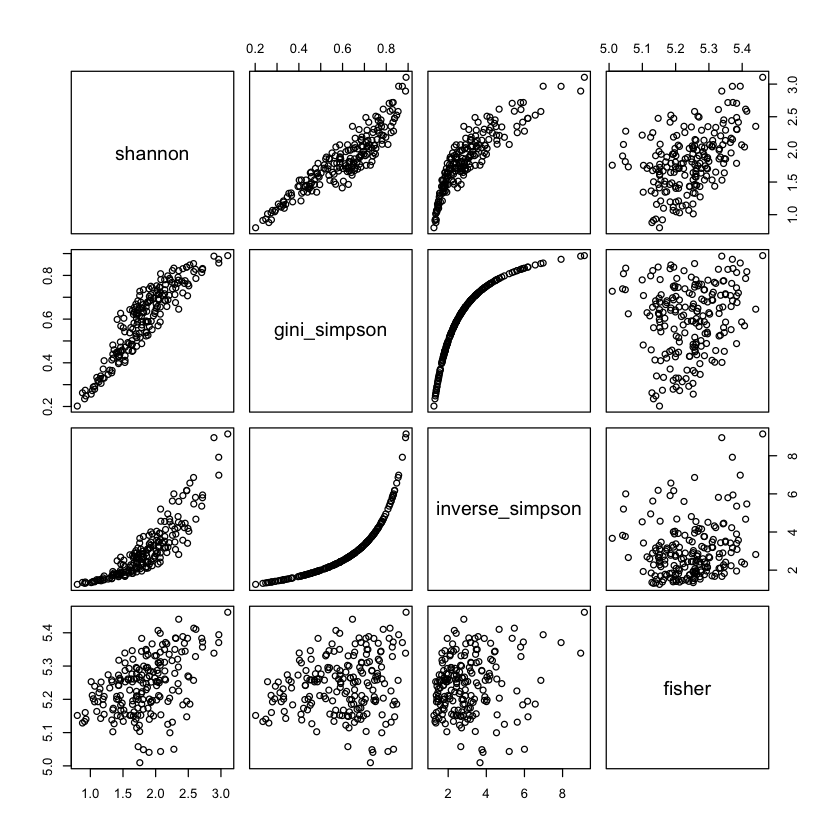

shannon   gini_simpson inverse_simpson fisher   
shannon         1.0000000 0.9164825    0.8751894       0.4663436
gini_simpson    0.9164825 1.0000000    0.8733146       0.1690173
inverse_simpson 0.8751894 0.8733146    1.0000000       0.1793259
fisher          0.4663436 0.1690173    0.1793259       1.0000000

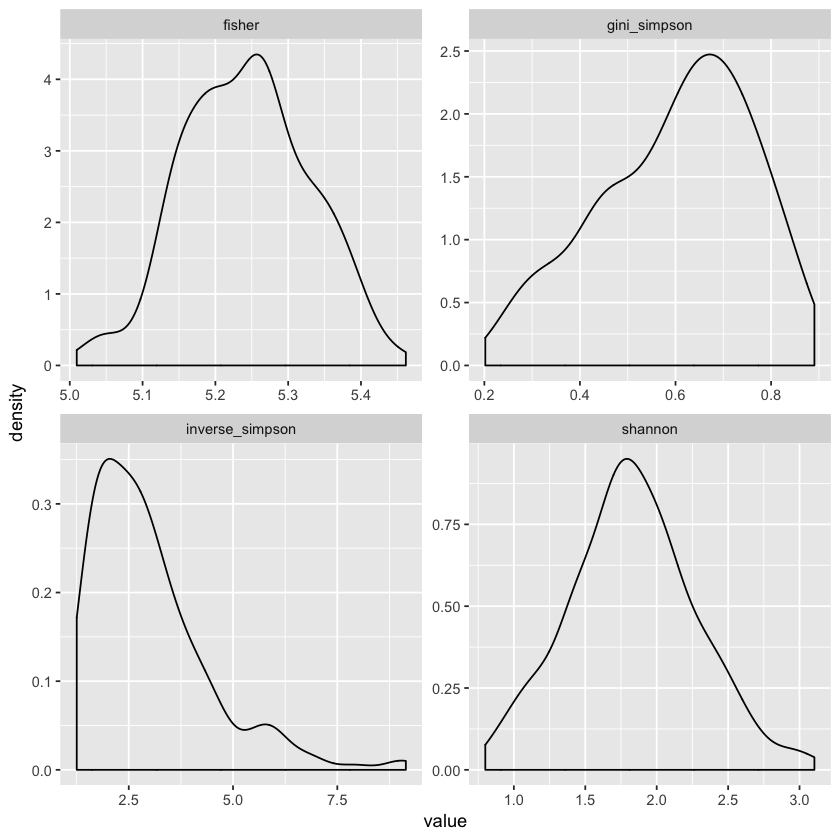

In [21]:
data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    pairs()

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    gather(index, value) %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~index, scales = "free")

data %>% 
    select(shannon, gini_simpson, inverse_simpson, fisher) %>%
    cor()

In [22]:
folder <- here("models/alpha_diversity")
diversity_index <- c("shannon", "inverse_simpson", "gini_simpson")

### Model specification
I will define different models using either gaussian or skew_normal distribution and also using either the integrated missing value treatment from BRMS or not. The rationale behind using it is that I will have more power to evaluate the hypotheses whether CC has effect on MB. Breastfeeding is a covariate and the uncertainty introduced imputation will be reflected in the posterior. 

The skew_normal should better be able to deal with the inverse simpson but in the end both should be fine.

In [23]:
# # create directories
# lapply(diversity_index, function(x) {
#     dir.create(glue("{folder}/{x}"))
#     dir.create(glue("{folder}/{x}/gaussian"))
#     dir.create(glue("{folder}/{x}/skew_normal"))
# })

In [24]:
prior <- 
    c(
        set_prior("normal(0, 1)", class = "b"),
        set_prior("exponential(20)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )
prior_skew <- 
    c(
        set_prior("normal(0, 1)", class = "b"),
        set_prior("exponential(25)", class = "sd"),
        set_prior("normal(0, 10)", class = "Intercept"),
        set_prior("lkj(2)", class = "cor")
    )
brm_div <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}


brm_div_multiple <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_multiple")
        #fit model
        brm_multiple(
            family = gaussian(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior, file = model_file
        )
}

brm_div_multiple_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_multiple_skew")
        #fit model
        brm_multiple(
            family = skew_normal(), data = data_imp, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15),
            prior = prior_skew, file = model_file
        )
}


brm_div_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/gaussian/full_mi")
        #fit model
        brm(
            family = gaussian(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

brm_div_skew <- 
    function(diversity_index) {
        # formula
        f <- as.formula(glue("{diversity_index} ~ cc*time + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id)"))
        formula <- bf(f) 
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999), 
            prior = prior, file = model_file
        )
}


brm_div_skew_mi <- function(diversity_index) {
        # delete _ for prior
        div_prior <- gsub("_", "", diversity_index)
        # specify prior 
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = div_prior),
            set_prior("exponential(15)", class = "sd", resp = div_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = div_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts"))
        # formula
        f1 <- as.formula(glue("{diversity_index} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
        f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {diversity_index} + age_d_s + (1 + time + age_d_s + {diversity_index}|subject_id)"))
        formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
        model_file <- glue("{folder}/{diversity_index}/skew_normal/full_mi")
        #fit model
        brm(
            family = skew_normal(), data = data, formula = formula,
            warmup = 1000, control = list(adapt_delta = 0.9999, max_treedepth = 15), 
            prior = prior_n, file = model_file
        )
}

In [25]:
glue("{folder}/{diversity_index}/gaussian/full_multiple")

/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/shannon/gaussian/full_multiple
/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/inverse_simpson/gaussian/full_multiple
/Users/henrikeckermann/workspace/research_master/minor_research_project/article/analyses/bibo/models/alpha_diversity/gini_simpson/gaussian/full_multiple

In [26]:
#pp_div_m_skew <- future_map2(div_models_m_skew, diversity_index, ~pp_plot(.x, 10, .y))
#pp_div_m_v2_skew <- future_map2(div_models_m_skew, diversity_index, ~pp_plot_v2(.x, 10, .y))
#pp_div_m_skew
#pp_div_m_v2_skew

In [27]:
#pp_div_m <- future_map2(div_models_m, diversity_index, ~pp_plot(.x, 10, .y))
#pp_div_m_v2 <- future_map2(div_models_m, diversity_index, ~pp_plot_v2(.x, 10, .y))
#pp_div_m
#pp_div_m_v2

In [28]:
# use this for brm multiple
calc_treatment_effect_div <- function(div, summarise = TRUE, stat = "mean") {
    model <- brm_div_multiple_skew(div)
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_ccyes:timepost")) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_ccyes:timepost")) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre)   %>%
    select(noccpre, ccpre, noccpost, ccpost)
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
    }
    df
}


In [29]:
compare_groups_div <- function(df_div) {
    df <- calc_treatment_effect(div, summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre,
            noccpost_ccpre = noccpost - ccpre) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, noccpost_ccpre) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean_diff = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df
}

In [30]:
df_div <- map(diversity_index, calc_treatment_effect_div, FALSE)
df_sum_div <- map(diversity_index, calc_treatment_effect_div, TRUE)

In [72]:
# change group names for plotting
data <- data %>% mutate(
    group = ifelse(groups == "noCCpost", "noccpost", ifelse(groups == "CCpost", "ccpost", ifelse(groups == "CCpre", "ccpre", "noccpre"))))
# visualize difference
plot_effects <- function(div, df_div, data = data) {
    title = gsub("_", " ", div)
    title = str_to_title(title)
    df_div_gathered <- df_div %>% gather(group, value)
    data %>% mutate(subject_id = as.factor(subject_id)) %>%
    ggplot(aes_string("group", div, group = "subject_id")) +
        geom_point(alpha = 0.3, size = 0.5) +
        geom_path(alpha = 0.3, size = 0.25) +
        geom_jitter(data = df_div_gathered, aes(x = group, y = value, group = ""), width = 0.05, alpha = 0.005, color = "#fc8d62") +
        scale_x_discrete(limits=c("noccpre", "noccpost", "ccpre", "ccpost")) +
        ylab(title) + xlab("") +
        theme_bw()
}

p_div <- map2(diversity_index, df_div, plot_effects, data)

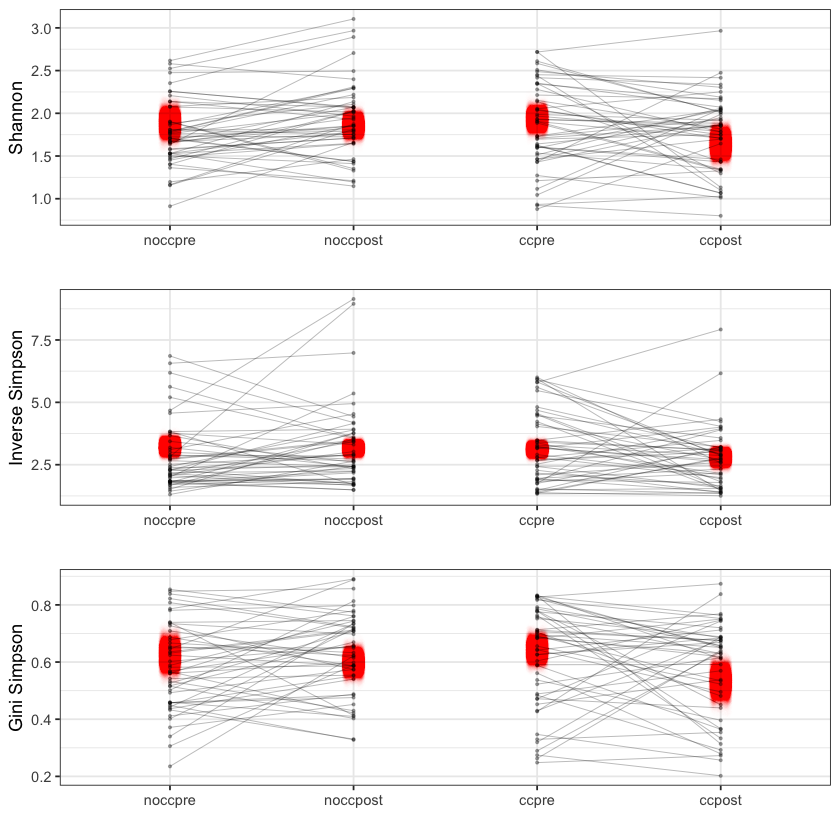

In [73]:
ggarrange(p_div[[1]], p_div[[2]], p_div[[3]], nrow = 3)


# Differential abundance testing

In [33]:
# specify prior (i did not specifiy sigma and alpha)
prior <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
prior_refit <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(55)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))
prior_refit2 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(65)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))

prior_refit3 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(75)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))

prior_refit4 <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(100)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
folder <- here("models/differential_abundance/skew_normal/mice/")

# define fitting function for fixed sigma for mice object
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/{genus}_full_multiple")
    #fit model
    brm_multiple(
        family = skew_normal(), data = data_imp, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}

brm_sn_multiple_fut <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/{genus}_full_multiple")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

brm_sn_multiple_fut_refit <- function(genus) future({
    tryCatch(
        {
            # specify formula
            f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
            formula <- bf(f_d)
            # give individual model name for storage
            model_file <- glue("{folder}/refit/{genus}_full_multiple")
            #fit model
            brm_multiple(
                family = skew_normal(), data = data_imp, formula = formula,
                chains = 4, warmup = 1000,
                control = control, prior = prior_refit4, file = model_file
                )
        },
        error=function(cond) {
            # Choose a return value in case of error
            return(cond)
        }
    )
})

# define fitting function for fixed sigma and imputation on the fly
brm_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula <- bf(f_d)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior, file = model_file
        )
    
}
        
        
# define fitting function for fixed sigma
brm_sn_mi <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(25)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(25)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}
     

        
        
# specify prior 
prior_d <- c(
            set_prior("normal(0, 2)", class = "b"),
            set_prior("exponential(25)", class = "sd"),
            set_prior("normal(0, 10)", class = "Intercept"), 
            set_prior("normal(0, 2)", class = "b", dpar = "sigma"),
            set_prior("exponential(25)", class = "sd", dpar = "sigma"),
            set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma"),
            set_prior("lkj(2)", class = "cor"))


control <-  list(adapt_delta = 0.9999, max_treedepth = 15)
# folder 
folder_d <- here("models/cc_vs_nocc")

# define fitting function distributional
brmd_sn <- function(genus) {
    # specify formula
    f_d <- as.formula(glue("{genus} ~ 1 + time*cc + age_d_s + bf_count_s + (1+ time + age_d_s + bf_count_s|subject_id)"))
    formula_d <- bf(f_d, sigma ~ 1 + time*cc + age_d_s + bf_count_s + (1 + time + age_d_s + bf_count_s|subject_id))
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_d, file = model_file
        )
    
}

# define fitting function distributional + mi
brmd_sn_mi <- function(genus) {
    # delete _ for prior
    sub_prior <- gsub("_", "", genus)
    sub_prior <- gsub("\\.", "", sub_prior)
    # specify prior for mi version
    prior_n <- c(
        set_prior("normal(0, 2)", class = "b", resp = sub_prior),
        set_prior("exponential(15)", class = "sd", resp = sub_prior),
        set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
        set_prior("lkj(2)", class = "cor"),     
        set_prior("normal(0, 2)", class = "b", dpar = "sigma", resp = sub_prior),
        set_prior("exponential(25)", class = "sd", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 5)", class = "Intercept", dpar = "sigma", resp = sub_prior),
        set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
        set_prior("exponential(15)", class = "sd", resp = "bfcounts"),
        set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
    )
    # specify formula
    f1 <- as.formula("Enterococcus |mi() ~ 1+ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)")
    f1 <- bf(f1, sigma ~ 1 + time*cc + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id))
    f2 <- as.formula("bf_count_s |mi() ~ 1 + cc*time + Enterococcus + age_d_s + (1 + time + age_d_s + Enterococcus|subject_id)")
    formula_d <- bf(f1) + bf(f2) + set_rescor(FALSE) 
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_d_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula_d,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

# this function I added for the exluded_id (see below)
# define fitting function for fixed sigma
brm_sn_mi_ex <- function(genus) {
        # delete _ for prior
        sub_prior <- gsub("_", "", genus)
        sub_prior <- gsub("\\.", "", sub_prior)
        # specify prior for mi version
        prior_n <- c(
            set_prior("normal(0, 2)", class = "b", resp = sub_prior),
            set_prior("exponential(35)", class = "sd", resp = sub_prior),
            set_prior("normal(0, 10)", class = "Intercept", resp = sub_prior), 
            set_prior("lkj(2)", class = "cor"),             
            set_prior("normal(0, 2)", class = "b", resp = "bfcounts"),
            set_prior("exponential(35)", class = "sd", resp = "bfcounts"),
            set_prior("normal(0, 10)", class = "Intercept", resp = "bfcounts")
        )
    # specify formula
    f1 <- as.formula(glue("{genus} |mi() ~ cc*time + age_d_s + mi(bf_count_s) + (1 + time + age_d_s + mi(bf_count_s)|subject_id)"))
    f2 <- as.formula(glue("bf_count_s |mi() ~ cc*time + {genus} + age_d_s + (1 + time + age_d_s + {genus}|subject_id)"))
    formula <- bf(f1) + bf(f2) + set_rescor(FALSE)
    # give individual model name for storage
    model_file <- glue("{folder}/skew_normal/{genus}_full_mi")
    #fit model
    brm(
        family = skew_normal(), data = data, formula = formula,
        chains = 4, warmup = 1000,
        control = control, prior = prior_n, file = model_file
        )
    
}

In [34]:
#plan(multiprocess)
#map(files[excluded_ids], brm_sn_multiple_fut_refit)
#models <- future_map(models_fut, value)

In [114]:
# model screening/excluding 
return_diag <- function(fit, genus) {
    sum_fit <- summary(fit)
    params <- rbind(sum_fit$fixed, sum_fit$random$subject_id, sum_fit$spec_pars) %>% as.data.frame()
    # extract n of divergent transitions
    n_divergent <- nuts_params(fit) %>% 
        filter(Parameter == "divergent__") %>% 
        summarise(n = sum(Value))
    # extract n of rhat > 1.1        
    n_high_rhat <- dim(filter(params, Rhat >= 1.1))[1]
    # check if there are rhat > 1.1 or divergent transitions
    if (n_high_rhat > 0) {
        message(glue("{genus} has {n_high_rhat} high Rhat parameter values"))
        return(FALSE)
    } else if (n_divergent$n > 0){
        message(glue("{genus} has {n_divergent$n} divergent transitions"))
        return(FALSE)
    } 
    TRUE
}

calc_mu_diff <- function(model, summarise = TRUE, stat = "mean") {
    df <- posterior_samples(model) %>%
        select(
            glue("b_Intercept"), 
            glue("b_ccyes"), 
            glue("b_timepost"), 
            glue("b_timepost:ccyes"), 
            glue("b_age_d_s"), 
            glue("b_bf_count_s")
        ) %>%
        rename(
            noccpre = glue("b_Intercept"), 
            ccpre = glue("b_ccyes"),
            noccpost = glue("b_timepost"),
            ccpost = glue("b_timepost:ccyes"),
            age = glue("b_age_d_s"),
            bf = glue("b_bf_count_s")
        ) %>%
        mutate(
            ccpost = noccpre + ccpre + noccpost + ccpost,
            noccpost = noccpre + noccpost,
            ccpre = noccpre + ccpre
    )    
    if (summarise) {
        df <- df %>% gather(group, value) %>%
            group_by(group) %>%
            do(data.frame(
                central = ifelse(stat == "median", median(.$value), mean(.$value)),
                lower = hpdi(.$value)[1],
                upper = hpdi(.$value)[2]
            ))
        
    }
    df 
}

plot_diff <- function(model) {
    df_sum <- calc_mu_diff(model)
    df <- calc_mu_diff(model, summarise = F)
    # plot
    df %>% gather(group, value) %>%
        ggplot(aes(x = group, value)) +
            geom_jitter(alpha = 0.05, color = "darkred") +
            geom_point(data = df_sum, aes(x = group, y = central), size = 2, color = "red") +
            geom_errorbar(data = df_sum, aes(x = group, y = central,  ymin = lower, ymax = upper), color = "darkred") +
            theme_bw()
}
compare_groups <- function(fit, genus) {
    df <- calc_mu_diff(fit,  summarise = F)
    df <- df %>% 
        mutate(            
            ccpost_ccpre = ccpost - ccpre,
            ccpost_noccpre = ccpost - noccpre,
            ccpost_noccpost = ccpost - noccpost,
            ccpre_noccpre = ccpre - noccpre,
            noccpost_noccpre = noccpost - noccpre,
            ccpre_noccpost = ccpre - noccpost) %>%
        select(ccpost_ccpre, ccpost_noccpre, ccpost_noccpost, ccpre_noccpre, noccpost_noccpre, ccpre_noccpost, age, bf) %>%
        gather(comparison, value) %>%
        group_by(comparison) %>%
        do(data.frame(
            mean = mean(.$value),
            lower = hpdi(.$value)[1],
            upper = hpdi(.$value)[2],
            prob = mean(.$value < 0)
        ))
    df %>% add_column(genus = genus)
}

return_comparisons <- function(genus) {
    fit_fut <- brm_sn_multiple_fut(genus)
    fit <- value(fit_fut)
    # can we go on with the model?
    if (!return_diag(fit, genus)) {
        return(genus = NA)
    }
    
    # else go on and compare groups
    compare_groups(fit, genus)
}

return_comparisons_refit <- function(genus) {
    fit_fut <- brm_sn_multiple_fut_refit(genus)
    fit <- value(fit_fut)
    # can we go on with the model?
    if (!return_diag(fit, genus)) {
        return(genus = NA)
    }
    
    # else go on and compare groups
    compare_groups(fit, genus)
}

In [115]:
#refit_gs <- gsub("_full_multiple.rds", "", list.files(here("models/differential_abundance/skew_normal/mice/refit")))

In [116]:
#for (genus in converged_models[excluded_ids]) {
#    fit_fut <- brm_sn_multiple_fut(genus)
#    fit <- values(fit_fut)
#    print(summary(fit))
#}

In [117]:
#map(refit_gs, ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}_full_multiple.rds"))))
#map(genus_refit[excluded_ids], ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}"))))

In [118]:
converged_models <- list.files(here(glue("models/differential_abundance/skew_normal/mice/")))
converged_models <- gsub("_full_multiple.rds", "", converged_models)
converged_models <- converged_models[-123]
converged_models

[1] "Actinomycetaceae"                  "Aerococcus"                       
  [3] "Aeromonas"                         "Akkermansia"                      
  [5] "Alcaligenesfaecalisetrel"          "Allistipesetrel"                  
  [7] "Anaerobiospirillum"                "Anaerofustis"                     
  [9] "Anaerostipescaccaeetrel"           "Anaerotruncuscolihominisetrel"    
 [11] "Anaerovoraxodorimutansetrel"       "Aneurinibacillus"                 
 [13] "Aquabacterium"                     "Asteroleplasmaetrel"              
 [15] "Bacillus"                          "Bacteroidesfragilisetrel"         
 [17] "Bacteroidesintestinalisetrel"      "Bacteroidesovatusetrel"           
 [19] "Bacteroidesplebeiusetrel"          "Bacteroidessplachnicusetrel"      
 [21] "Bacteroidesstercorisetrel"         "Bacteroidesuniformisetrel"        
 [23] "Bacteroidesvulgatusetrel"          "Bifidobacterium"                  
 [25] "Bilophilaetrel"                    "Brachyspira"                      
 [27] "Bryantellaformatexigensetrel"      "Bulleidiamooreietrel"             
 [29] "Burkholderia"                      "Campylobacter"                    
 [31] "Clostridiumcellulosietrel"         "Clostridiumcolinumetrel"          
 [33] "Clostridiumdifficileetrel"         "Clostridiumfelsineumetrel"        
 [35] "Clostridiumleptumetrel"            "Clostridiumorbiscindensetrel"     
 [37] "Clostridiumramosumetrel"           "Clostridiumsensustricto"          
 [39] "Clostridiumsphenoidesetrel"        "Clostridiumstercorariumetrel"     
 [41] "Clostridiumsymbiosumetrel"         "Clostridiumthermocellumetrel"     
 [43] "Collinsella"                       "Coprobacilluscatenaformisetrel"   
 [45] "Coprococcuseutactusetrel"          "Corynebacterium"                  
 [47] "Desulfovibrioetrel"                "Dialister"                        
 [49] "Doreaformicigeneransetrel"         "Eggerthellalentaetrel"            
 [51] "Enterobacteraerogenesetrel"        "Enterococcus"                     
 [53] "Escherichiacolietrel"              "Eubacteriumbiformeetrel"          
 [55] "Eubacteriumcylindroidesetrel"      "Eubacteriumhalliietrel"           
 [57] "Eubacteriumlimosumetrel"           "Eubacteriumrectaleetrel"          
 [59] "Eubacteriumsiraeumetrel"           "Eubacteriumventriosumetrel"       
 [61] "Faecalibacteriumprausnitziietrel"  "Fusobacteria"                     
 [63] "Gemella"                           "Granulicatella"                   
 [65] "Haemophilus"                       "Helicobacter"                     
 [67] "Klebisiellapneumoniaeetrel"        "Lachnobacillusbovisetrel"         
 [69] "Lachnospirapectinoschizaetrel"     "Lactobacilluscatenaformisetrel"   
 [71] "Lactobacillusgasserietrel"         "Lactobacillusplantarumetrel"      
 [73] "Lactobacillussalivariusetrel"      "Lactococcus"                      
 [75] "Leminorella"                       "Megamonashypermegaleetrel"        
 [77] "Megasphaeraelsdeniietrel"          "Methylobacterium"                 
 [79] "Micrococcaceae"                    "Mitsuokellamultiacidaetrel"       
 [81] "Moraxellaceae"                     "Novosphingobium"                  
 [83] "Oceanospirillum"                   "Oscillospiraguillermondiietrel"   
 [85] "Oxalobacterformigenesetrel"        "Papillibactercinnamivoransetrel"  
 [87] "Parabacteroidesdistasonisetrel"    "Peptococcusnigeretrel"            
 [89] "Peptostreptococcusanaerobiusetrel" "Peptostreptococcusmicrosetrel"    
 [91] "Phascolarctobacteriumfaeciumetrel" "Prevotellamelaninogenicaetrel"    
 [93] "Prevotellaoralisetrel"             "Prevotellaruminicolaetrel"        
 [95] "Prevotellatanneraeetrel"           "Propionibacterium"                
 [97] "Proteusetrel"                      "Pseudomonas"                      
 [99] "Roseburiaintestinalisetrel"        "Ruminococcusbromiietrel"          
[101] "Ruminococcuscallidusetrel"         "Ruminococcusgnavusetrel"          
[103] "Ruminococcusobeum

In [119]:
plan(multiprocess)
comp_all <- future_map(converged_models, return_comparisons)

In [120]:
# I used this until all models converged
excluded_ids <- which(is.na(comp_all))
converged_models[excluded_ids]
comp_all_complete <- comp_all[!is.na(comp_all)]
length(comp_all)
#map(files[excluded_ids], ~file.remove(here(glue("models/differential_abundance/skew_normal/mice/{.x}_full_multiple.rds"))))
comp_all %>% head(2)

character(0)

[1] 122

[[1]]
# A tibble: 8 x 6
# Groups:   comparison [8]
  comparison           mean    lower  upper   prob genus           
  <chr>               <dbl>    <dbl>  <dbl>  <dbl> <chr>           
1 age              -0.0322  -0.107   0.0458 0.801  Actinomycetaceae
2 bf               -0.0204  -0.0718  0.0298 0.788  Actinomycetaceae
3 ccpost_ccpre      0.0715  -0.0631  0.207  0.148  Actinomycetaceae
4 ccpost_noccpost   0.101   -0.00992 0.209  0.0358 Actinomycetaceae
5 ccpost_noccpre    0.0974  -0.0867  0.279  0.149  Actinomycetaceae
6 ccpre_noccpost    0.0296  -0.0960  0.156  0.323  Actinomycetaceae
7 ccpre_noccpre     0.0259  -0.0749  0.131  0.309  Actinomycetaceae
8 noccpost_noccpre -0.00367 -0.136   0.129  0.521  Actinomycetaceae

[[2]]
# A tibble: 8 x 6
# Groups:   comparison [8]
  comparison           mean   lower   upper   prob genus     
  <chr>               <dbl>   <dbl>   <dbl>  <dbl> <chr>     
1 age               0.0527  -0.0201  0.122  0.0734 Aerococcus
2 bf               -0.0682  -0.112  -0.0228 0.998  Aerococcus
3 ccpost_ccpre     -0.0801  -0.216   0.0498 0.882  Aerococcus
4 ccpost_noccpost  -0.0301  -0.138   0.0752 0.708  Aerococcus
5 ccpost_noccpre   -0.00543 -0.180   0.170  0.529  Aerococcus
6 ccpre_noccpost    0.0500  -0.0714  0.180  0.214  Aerococcus
7 ccpre_noccpre     0.0747  -0.0388  0.187  0.0930 Aerococcus
8 noccpost_noccpre  0.0247  -0.116   0.167  0.372  Aerococcus

In [121]:
comp_all_df <- map_df(comp_all_complete, bind_rows)

# the input for the plot_comp function will be nested dfs:
comp_all_nested <- comp_all_df %>% 
    group_by(comparison) %>%
    nest()

plot_comp <- function(data, comp) {
    all_comp <- data %>% mutate(prob = report_star_nondirectional(prob))
    n_genera <- length(all_comp$genus)
    part1 <- all_comp[1:n_genera/2, ]
    part2 <- all_comp[-c(1:n_genera/2), ]
    p <- map(list(part1, part2), ~ ggplot(
        .x, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-2, 2) +
        ggtitle(comp) +
        coord_flip() +
        theme_bw(base_size = 8))
    
    p
}


comparison_plots <- map2(comp_all_nested$data, comp_all_nested$comparison, plot_comp)


In [139]:
comp_article %>% filter(prob <= 0.05 | prob >= 0.95, comparison == "ccpost_noccpost", genus == "Streptococcusintermediusetrel")

comparison      mean       lower      upper       prob   
1 ccpost_noccpost -0.2875031 -0.5593308 -0.01669883 0.98115
  genus                        
1 Streptococcusintermediusetrel

[1] "age"              "bf"               "ccpost_ccpre"     "ccpost_noccpost" 
[5] "ccpost_noccpre"   "ccpre_noccpost"   "ccpre_noccpre"    "noccpost_noccpre"

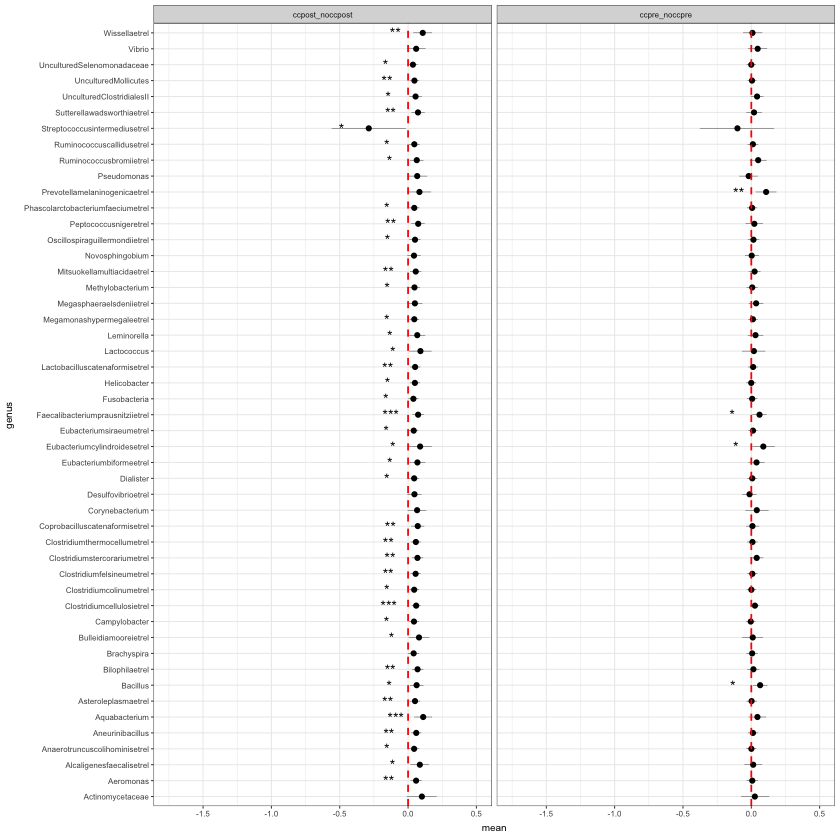

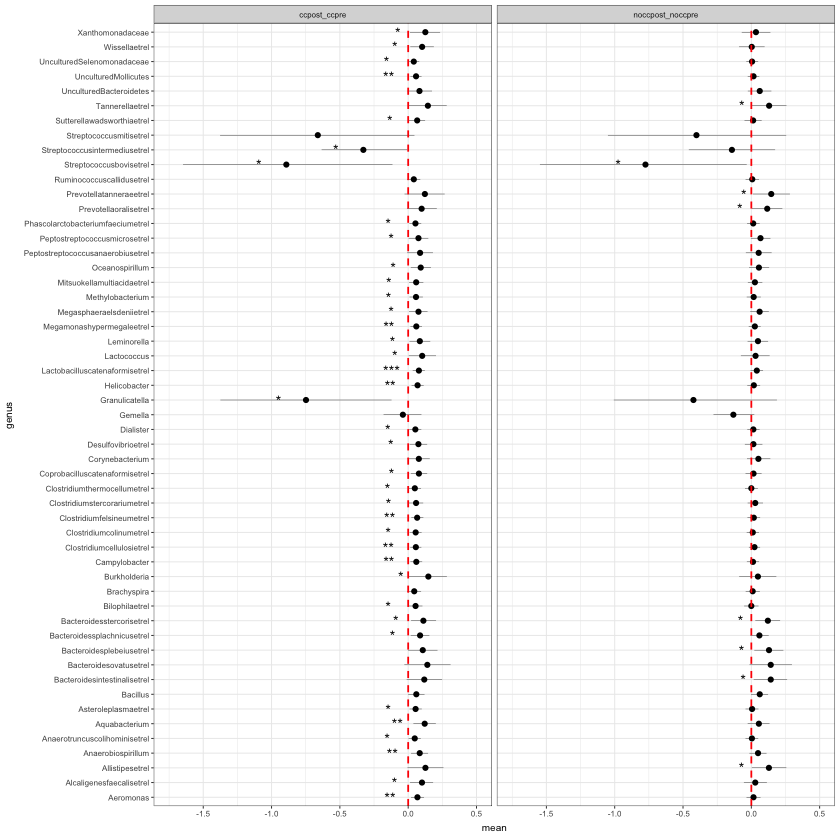

In [173]:
unique(comp_all_df$comparison)

comp_article_1 <- comp_all_df %>% filter(comparison  %in% c("ccpre_noccpre", "ccpost_noccpost"))
comp_article_2 <- comp_all_df %>% filter(comparison  %in% c("ccpost_ccpre", "noccpost_noccpre"))

filter_genus_1 <- comp_article_1 %>% 
    filter((comparison == "noccpre_ccpre" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "ccpost_noccpost" & (prob <= 0.05 | prob >= 0.95)))
filter_genus_2 <- comp_article_2 %>% 
    filter((comparison == "ccpost_ccpre" & (prob <= 0.05 | prob >= 0.95)) | (comparison == "noccpost_noccpre" & (prob <= 0.05 | prob >= 0.95)))

plot_comp_article <- function(data, filter_genus) {
    all_comp <- data %>% mutate(prob = report_star_nondirectional(prob)) %>%
        filter(genus %in% filter_genus$genus)
    
    p <- ggplot(all_comp, aes(genus, mean, label = prob)) +
        geom_pointrange(aes(ymin = lower, ymax = upper), size = 0.1) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = - 0.2, size = 3) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
        ylim(-1.75, 0.5) +
        facet_wrap(~comparison) +
        coord_flip() +
        theme_bw(base_size = 6)
    
    p
}
comparison_plots_article_1 <- plot_comp_article(comp_article_1, filter_genus_1)
comparison_plots_article_2 <- plot_comp_article(comp_article_2, filter_genus_2)

comparison_plots_article_1
comparison_plots_article_2

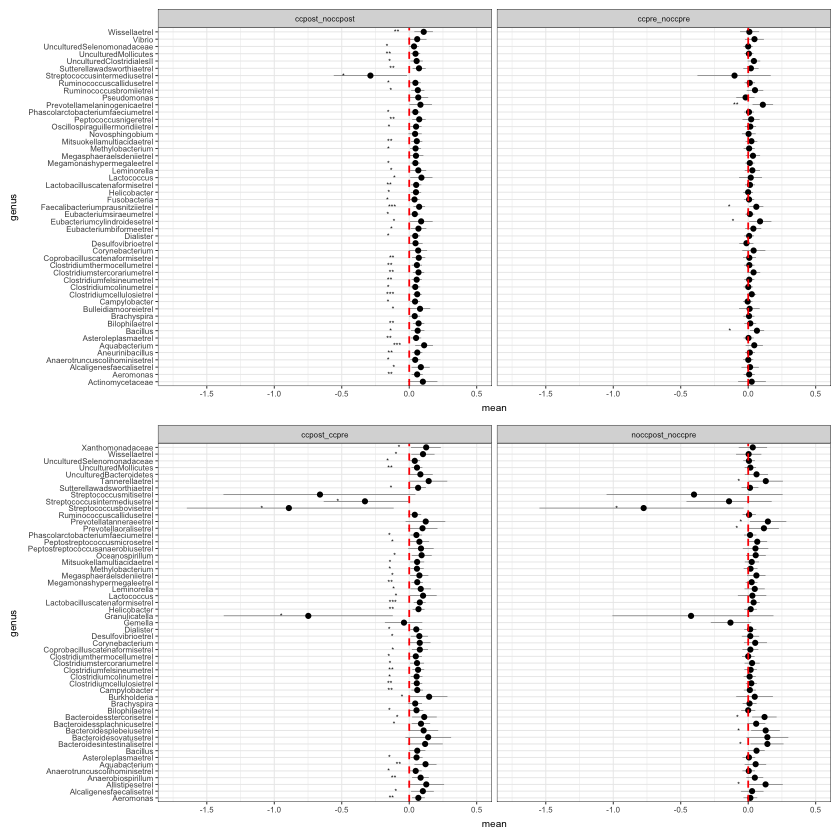

In [165]:
library(patchwork) 
comparison_plots_article / comparison_plots_article_2

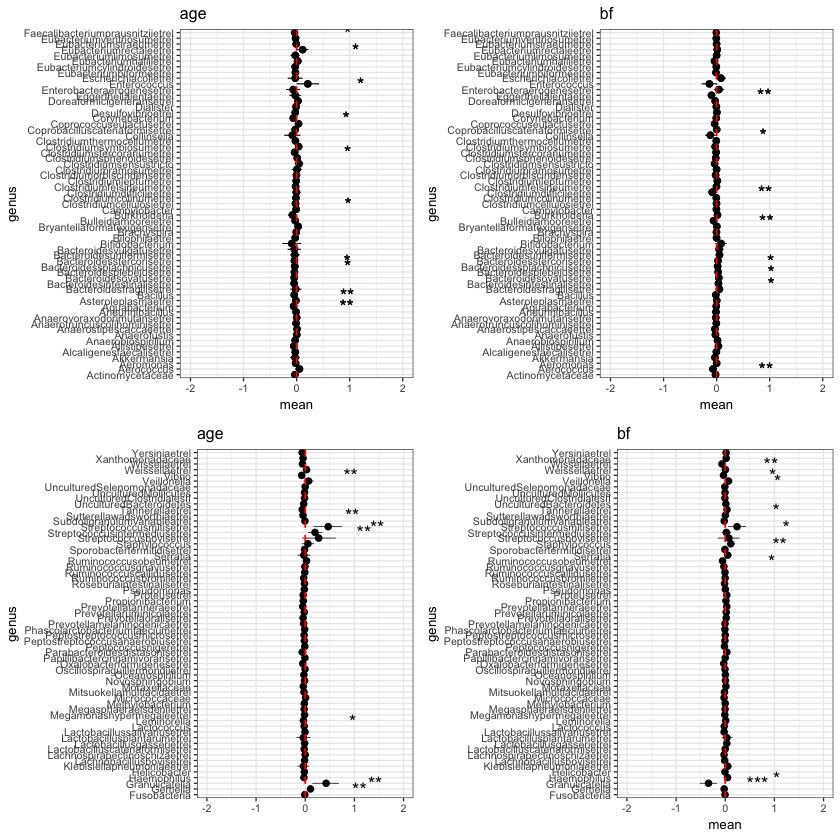

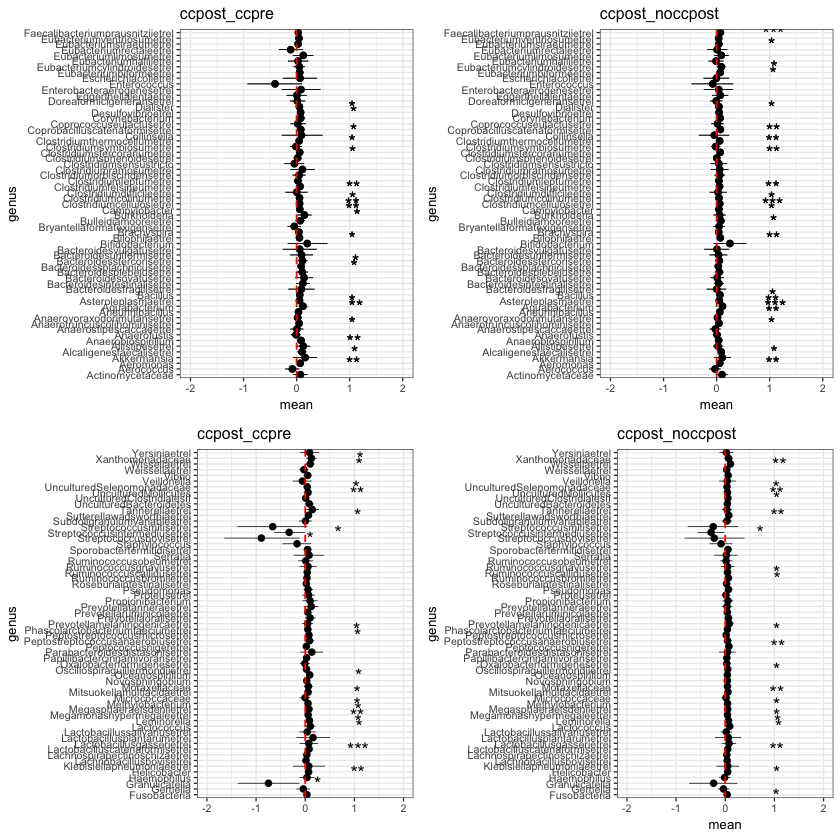

In [159]:
library(ggpubr)
ggarrange(
    comparison_plots[[1]][[1]], comparison_plots[[2]][[1]],
    comparison_plots[[1]][[2]] + ylab(""), comparison_plots[[2]][[2]],
    nrow = 2, ncol = 2, common.legend = T
)


ggarrange(
    comparison_plots[[3]][[1]], comparison_plots[[4]][[1]],
    comparison_plots[[3]][[2]] + ylab(""), comparison_plots[[4]][[2]],
    nrow = 2, ncol = 2, common.legend = T
)

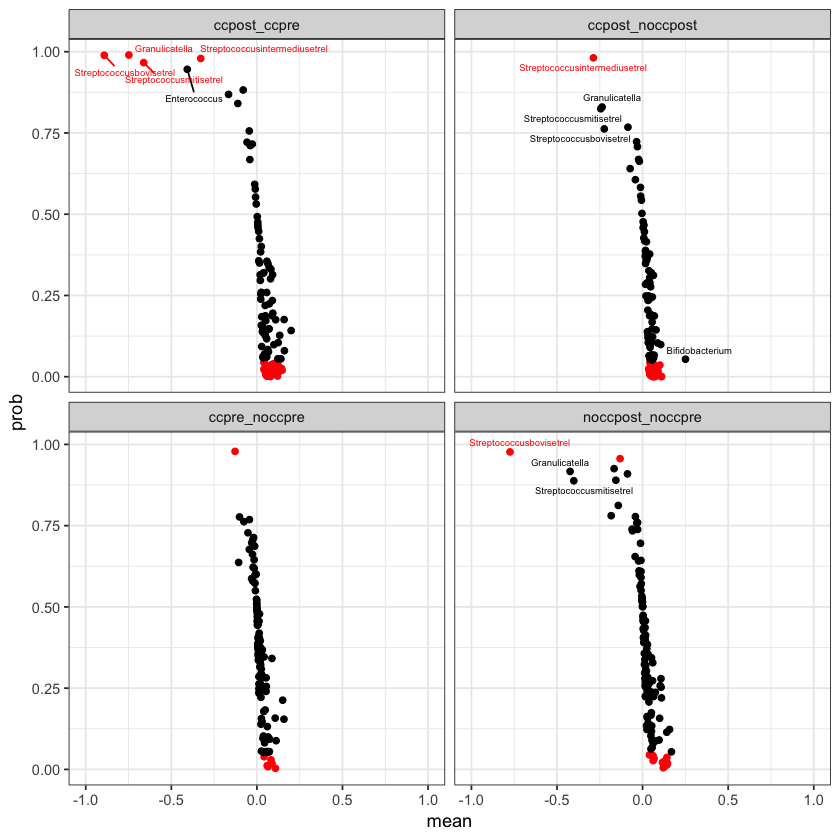

In [186]:
library(ggrepel)

differential_abundance_plots <- map2(comp_all_nested$data, comp_all_nested$comparison, ~.x %>% 
    arrange(prob) %>% 
    mutate(qvalue = cummean(prob)) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.025 | prob >= 0.975, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
        geom_point() + 
        xlim(-1, 1) +
        ggtitle(.y) +
        scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
        geom_text_repel() +
        theme_bw() +
        theme(legend.position="none") 
   
   )
#differential_abundance_plots

comp_article <- comp_all_df %>% filter(comparison %in% c("ccpre_noccpre", "ccpost_noccpost", "ccpost_ccpre", "noccpost_noccpre"))

differential_abundance_plots_article <- comp_article %>% 
    arrange(prob) %>% 
    mutate(qvalue = cummean(prob)) %>%
    ggplot(aes(mean, prob, color = ifelse(prob <= 0.05 | prob >= 0.95, "sig", "notsig"), label = ifelse(abs(mean)>= 0.2, genus, ""))) +
        geom_point() + 
        xlim(-1, 1) +
        scale_colour_manual(values = c("sig" = "red", "notsig" = "black")) +
        geom_text_repel(size = 2) +
        facet_wrap(~comparison) +
        theme_bw() +
        theme(legend.position="none") 
differential_abundance_plots_article

In [46]:
# how often do we find differences per parameter/comparison?
comp_all_df %>%
    filter(prob < 0.025 | prob > 0.975) %>%
    group_by(comparison) %>%
    summarise(n = n())

comparison       n 
1 age              17
2 bf               17
3 ccpost_ccpre     38
4 ccpost_noccpost  40
5 ccpost_noccpre   36
6 noccpost_ccpre    1
7 noccpost_noccpre  8
8 noccpre_ccpre     5

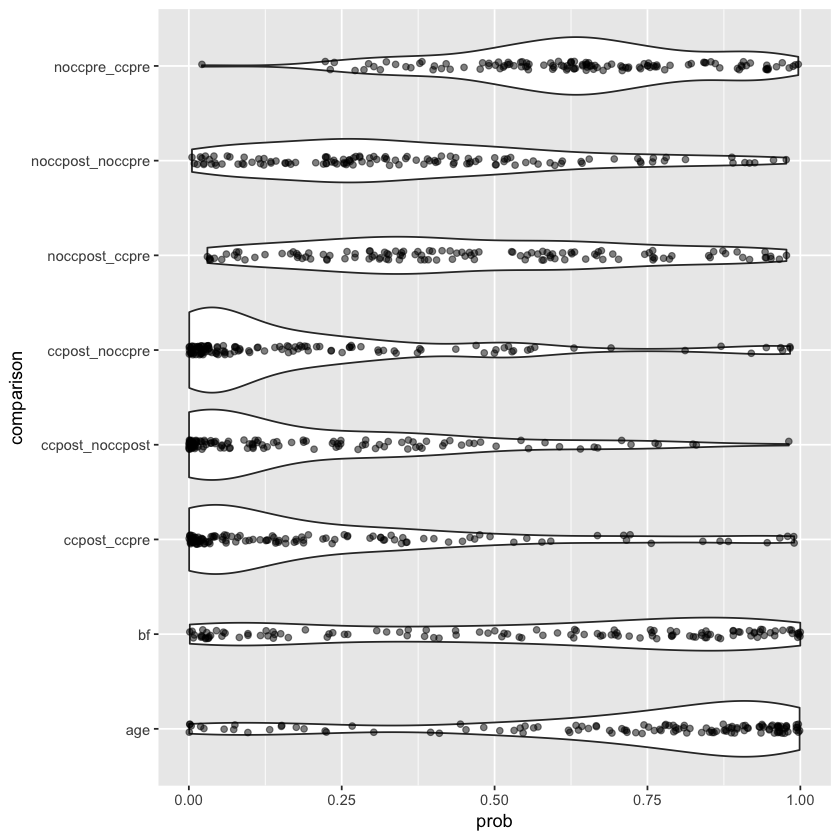

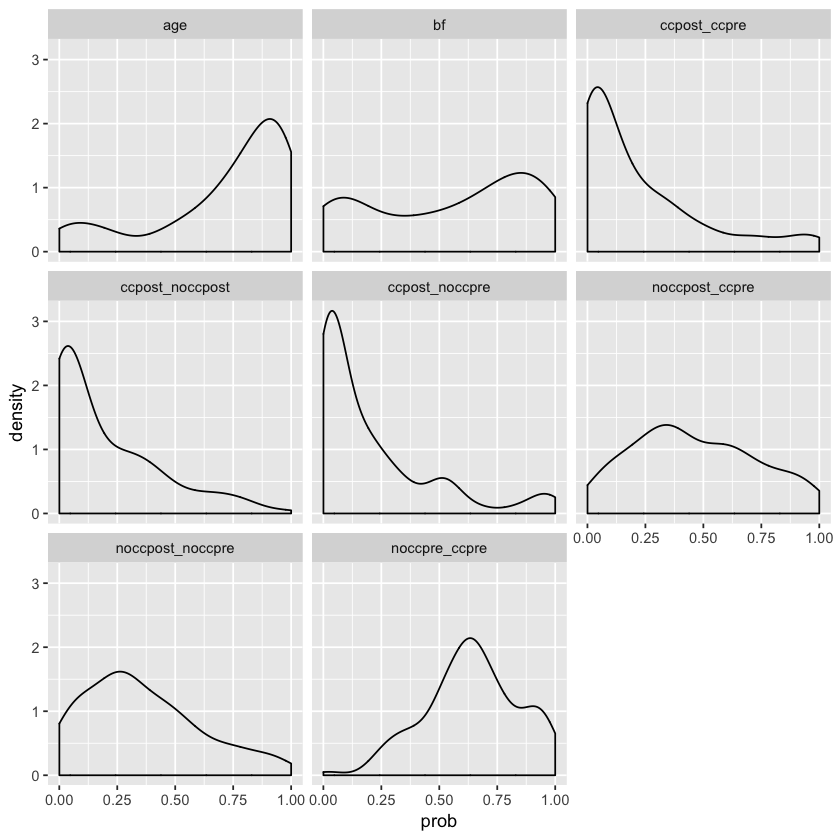

In [47]:
# how are the probabilities distributes? In my understanding, if there is no difference between ccpost
# and the other groups, thus the parameter mu is the same, then the probability that group difference is <0 should be close to 50%. 
# If the parameters where not similar but in a non-systematic way, then p should be uniformly distributed ?!
# But if there is a systematic difference I would expect p mostly either < 0.05 or >0.95
comp_all_df %>%
    ggplot(aes(comparison, prob)) +
    geom_violin() +
    geom_jitter(alpha = 0.5, width = 0.05) +
    coord_flip()

comp_all_df %>% 
    ggplot(aes(prob)) +
    geom_density() +
    facet_wrap(~comparison)

### Differential abundance LME4

In [48]:
library(lme4)
library(car)
library(qvalue)

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Attaching package: ‘lme4’

The following object is masked from ‘package:brms’:

    ngrps

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



In [49]:
# change contrasts for easy interpretability
reverse_c <- function(data) {
    contrasts(data$cc)[1, 1] <- 1
    contrasts(data$cc)[2, 1] <- 0
    contrasts(data$time)[1, 1] <- 1
    contrasts(data$time)[2, 1] <- 0
    data
}
data_imp_revc <- map(data_imp, reverse_c)

In [50]:
# test if it worked
data_imp_revc[[1]]$time %>% contrasts()

post
pre  1   
post 0

In [51]:
plan(multiprocess)
# fit models and pool estimates
lme4_fits <- 
    future_map(genus[-1], ~ data_imp_revc %>%
      map(lmer, formula = glue("{.x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")) %>%
      pool() %>%
      summary() %>%
      rownames_to_column("parameter") %>%
      mutate(parameter = c("intercept", "cc", "time", "age", "breastfeeding", "cc_time")) %>%
      add_column(genus = .x) 
    )

R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call
R_zmq_msg_send errno: 4 strerror: Interrupted system call


In [52]:
lme4_by_param <- lme4_fits %>% 
    map_df(bind_rows) %>%
    filter(parameter != "intercept") %>%
    group_by(parameter) %>%
    nest()

In [53]:
lme4_by_param$parameter

[1] "cc"            "time"          "age"           "breastfeeding"
[5] "cc_time"

In [54]:
# calculate q value for each set of parameters, allow for 25% false discoveries
lme4_by_param$data <- map(lme4_by_param$data, ~.x %>% mutate(q = qvalue(p.value)$qvalue))

lme4_final <- lme4_by_param %>% unnest()
lme4_table <- lme4_final %>% 
    filter(p.value<=0.05, q <= 0.2) %>%
    arrange(parameter, desc(abs(estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(parameter, genus, everything())

In [55]:
library(ggrepel)

params <- c("cc", "time", "age", "breastfeeding")

plot_comp <- function(comp, data) {
    all_comp <- data %>% mutate(p = report_star(p.value)) %>% filter(parameter == comp)
    n_genera <- length(all_comp$genus)
    part1 <- all_comp[1:n_genera/2, ]
    part2 <- all_comp[-c(1:n_genera/2), ]
    p <- map(list(part1, part2), ~ ggplot(
        .x, aes(genus, estimate, label = p)) +
        geom_pointrange(aes(ymin = estimate - 2*std.error, ymax =estimate + 2*std.error), size = 0.2) +
        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
        geom_text(nudge_y = 1) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "blue") +
        ylim(-2, 2) +
        ggtitle(comp) +
        coord_flip() +
        theme_bw(base_size = 8))
    
    p
}

lme4_plots <- map(params, plot_comp, lme4_final)

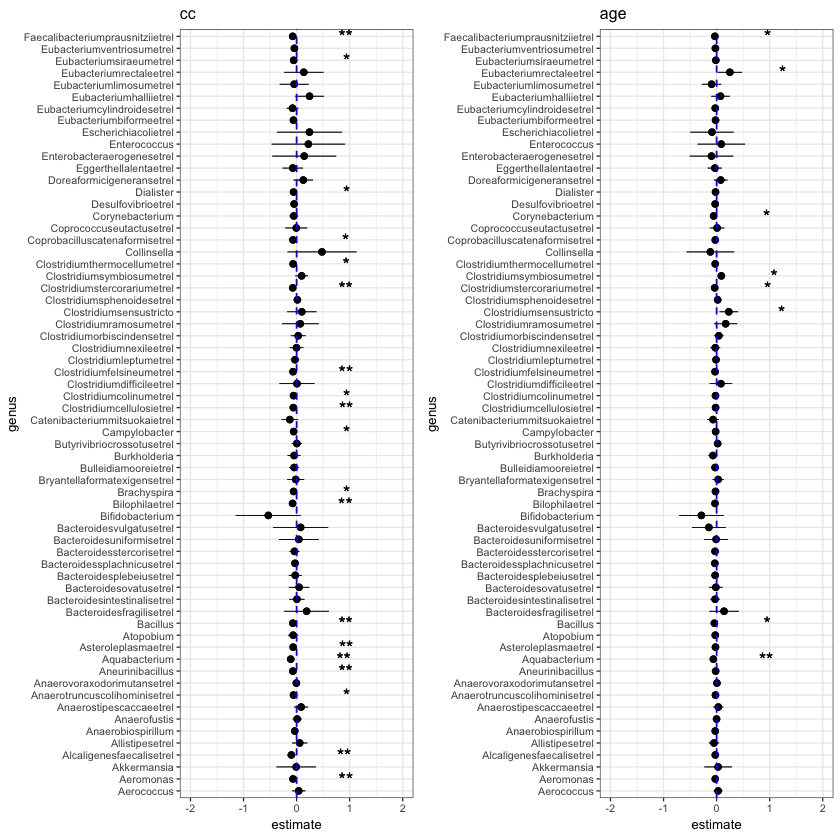

In [56]:
library(grid)

grid.draw(cbind(ggplotGrob(lme4_plots[[1]][[1]]), ggplotGrob(lme4_plots[[3]][[1]]), size = "last"))

In [57]:
lme4_final_table <-  lme4_final
colnames(lme4_final_table) <- str_to_title(colnames(lme4_final_table))
lme4_final_table %>%
    rename(P = P.value) %>%
    filter(P<=0.05, Q <= 0.2) %>%
    arrange(Parameter, desc(abs(Estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(Parameter, Genus, everything()) 

Parameter     Genus                             Estimate Std.error Statistic
1  age           Streptococcusmitisetrel            0.48    0.18       2.62    
2  age           Streptococcusintermediusetrel      0.36    0.13       2.79    
3  age           Eubacteriumrectaleetrel            0.25    0.12       2.16    
4  age           Clostridiumsensustricto            0.23    0.09       2.59    
5  age           Gemella                            0.16    0.06       2.73    
6  age           Clostridiumsymbiosumetrel          0.09    0.04       2.55    
7  age           Vibrio                            -0.09    0.03      -2.93    
8  age           Aquabacterium                     -0.06    0.02      -2.74    
9  age           Sutterellawadsworthiaetrel        -0.04    0.02      -2.49    
10 age           Bacillus                          -0.04    0.02      -2.58    
11 age           Clostridiumstercorariumetrel      -0.04    0.02      -2.25    
12 age           Faecalibacteriumprausnitziietrel  -0.03    0.02      -2.08    
13 breastfeeding Staphylococcus                     0.21    0.07       3.12    
14 breastfeeding Ruminococcusobeumetrel            -0.11    0.04      -2.64    
15 breastfeeding Eggerthellalentaetrel             -0.10    0.04      -2.83    
16 breastfeeding Wissellaetrel                     -0.10    0.03      -3.76    
17 breastfeeding Bulleidiamooreietrel              -0.09    0.02      -4.91    
18 breastfeeding Vibrio                            -0.05    0.02      -3.02    
19 cc            Streptococcusintermediusetrel      0.49    0.20       2.44    
20 cc            Wissellaetrel                     -0.15    0.07      -2.16    
21 cc            Lactococcus                       -0.13    0.05      -2.42    
22 cc            Aquabacterium                     -0.11    0.03      -3.22    
23 cc            Alcaligenesfaecalisetrel          -0.10    0.04      -2.69    
24 cc            Bilophilaetrel                    -0.08    0.03      -2.93    
25 cc            Faecalibacteriumprausnitziietrel  -0.07    0.03      -2.89    
26 cc            Clostridiumstercorariumetrel      -0.07    0.03      -2.85    
27 cc            Bacillus                          -0.07    0.03      -2.65    
28 cc            Aneurinibacillus                  -0.07    0.02      -2.87    
29 cc            Coprobacilluscatenaformisetrel    -0.07    0.03      -2.48    
30 cc            Aeromonas                         -0.07    0.02      -2.79    
⋮  ⋮             ⋮                                 ⋮        ⋮         ⋮        
59 time          Veillonella                        0.58    0.24       2.39    
60 time          Clostridiumsensustricto            0.55    0.17       3.26    
61 time          Aquabacterium                     -0.13    0.04      -3.11    
62 time          Oceanospirillum                   -0.12    0.04      -2.88    
63 time          Alcaligenesfaecalisetrel          -0.11    0.05      -2.42    
64 time          Lactobacilluscatenaformisetrel    -0.09    0.03      -2.73    
65 time          Bacteroidessplachnicusetrel       -0.09    0.03      -2.51    
66 time          Clostridiumfelsineumetrel         -0.08    0.03      -2.72    
67 time          Anaerobiospirillum                -0.08    0.03      -2.56    
68 time          Megamonashypermegaleetrel         -0.08    0.03      -2.66    
69 time          Aeromonas                         -0.08    0.03      -2.63    
70 time          Campylobacter                     -0.08    0.03      -2.64    
71 time          Megasphaeraelsdeniietrel          -0.08    0.03      -2.25    
72 time          Coprobacilluscatenaformisetrel    -0.08    0.03      -2.26    
73 time          Desulfovibrioetrel                -0.08    0.03      -2.35    
74 time          Helicobacter                      -0.08    0.03      -2.57    
75 time          Mitsuokellamultiacidaetrel        -0.07    0.03      -2.34    
76 time          Clostridiumcolinumetrel           -0.07    0.03      -2.47    
77 

In [58]:
str_to_title(colnames(lme4_final_table))
    

[1] "Parameter" "Estimate"  "Std.error" "Statistic" "Df"        "P.value"  
[7] "Genus"     "Q"

### Alpha diversity

In [59]:
# fit models and pool estimates
lme4_fits_div <- 
    map(diversity_index, ~ data_imp_revc %>%
      future_map(lmer, formula = glue("{.x} ~ cc*time + age_d_s + bf_count_s + (1|subject_id)")) %>%
      pool() %>%
      summary() %>%
      rownames_to_column("parameter") %>%
      mutate(parameter = c("intercept", "cc", "time", "age", "breastfeeding", "cc_time")) %>%
      add_column(index = .x) 
    )

In [60]:
lme4_by_param_div <- lme4_fits_div %>% 
    map_df(bind_rows) %>%
    filter(parameter != "intercept") %>%
    group_by(parameter) %>%
    nest()

In [61]:
# calculate q value for each set of parameters, allow for 25% false discoveries
#lme4_by_param_div$data <- map(lme4_by_param_div$data, ~.x %>% mutate(q = qvalue(p.value)$qvalue))
lme4_final_div <- lme4_by_param_div %>% unnest()
lme4_final_div %>%
    arrange(parameter, desc(abs(estimate))) %>%
    mutate_if(is.numeric, round, 2) %>%
    select(parameter, index, everything())

parameter     index           estimate std.error statistic df     p.value
1  age           inverse_simpson  0.33    0.20       1.66     185.89 0.10   
2  age           shannon          0.10    0.06       1.52     185.88 0.13   
3  age           gini_simpson     0.04    0.02       1.86     185.98 0.06   
4  breastfeeding inverse_simpson -0.10    0.12      -0.82     146.01 0.41   
5  breastfeeding shannon         -0.06    0.04      -1.73     167.46 0.08   
6  breastfeeding gini_simpson    -0.01    0.01      -0.53     176.86 0.60   
7  cc            inverse_simpson  0.64    0.31       2.05     185.98 0.04   
8  cc            shannon          0.22    0.10       2.30     185.89 0.02   
9  cc            gini_simpson     0.08    0.03       2.23     186.01 0.03   
10 cc_time       inverse_simpson -0.80    0.32      -2.48     185.91 0.01   
11 cc_time       shannon         -0.25    0.09      -2.74     185.65 0.01   
12 cc_time       gini_simpson    -0.09    0.04      -2.40     185.98 0.02   
13 time          inverse_simpson  0.98    0.38       2.58     185.77 0.01   
14 time          shannon          0.28    0.12       2.38     185.79 0.02   
15 time          gini_simpson     0.11    0.04       2.52     185.96 0.01

In [62]:
data %>% 
    group_by(time, cc) %>% 
    summarise(
        shannon = glue("M = {round(mean(shannon), 2)}, SD = {round(sd(shannon), 2)}"),
        inverse_simpson = glue("M = {round(mean(inverse_simpson),2)}, SD = {round(sd(inverse_simpson), 2)}"),
        gini_simpson = glue("M = {round(mean(gini_simpson),2)}, SD = {round(sd(gini_simpson), 2)}")
    )

time cc  shannon             inverse_simpson     gini_simpson       
1 pre  no  M = 1.77, SD = 0.38 M = 2.84, SD = 1.37 M = 0.58, SD = 0.15
2 pre  yes M = 1.86, SD = 0.49 M = 3.19, SD = 1.45 M = 0.62, SD = 0.18
3 post no  M = 1.93, SD = 0.44 M = 3.21, SD = 1.65 M = 0.63, SD = 0.14
4 post yes M = 1.76, SD = 0.45 M = 2.77, SD = 1.25 M = 0.57, SD = 0.17

In [187]:
save.image(file = here("data/cc_analyses_workspace.RData"))